# Quantization-Aware Training (QAT) on MNIST with PyTorch

This notebook demonstrates Quantization-Aware Training for a CNN on MNIST dataset.

Using device: cpu
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.36MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.51MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



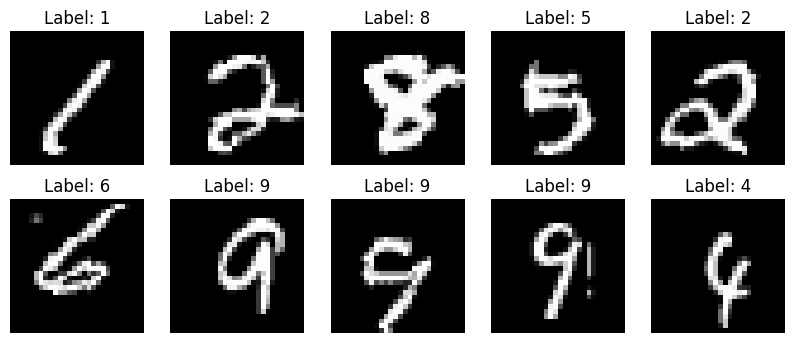

In [1]:
# 1. Dataset Preparation
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from torchsummary import summary
from torch.quantization import QuantStub, DeQuantStub, prepare_qat, convert

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load datasets with error handling
try:
    train_dataset = datasets.MNIST(
        root='./data', 
        train=True,
        download=True, 
        transform=train_transform
    )
    test_dataset = datasets.MNIST(
        root='./data', 
        train=False,
        download=True, 
        transform=test_transform
    )
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Visualize sample images
images, labels = next(iter(train_loader))
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')
plt.show()

## 2. Model Implementation

We define a CNN with:
- 2 convolutional blocks (Conv2d + BatchNorm + ReLU + MaxPool)
- Dropout for regularization
- Fully connected layers
- Quantization stubs for QAT

In [6]:
class QATCNN(nn.Module):
    def __init__(self):
        super(QATCNN, self).__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        
        # Feature extraction with explicit layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.dropout = nn.Dropout(0.25)
        
        # Classifier
        self.fc1 = nn.Linear(64*7*7, 128)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.quant(x)
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.relu3(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        x = self.dequant(x)
        return x
    
    def fuse_model(self):
        # Switch to eval mode for fusion
        self.eval()  # CRITICAL FIX: Set model to evaluation mode
        torch.quantization.fuse_modules(self, 
            [['conv1', 'bn1', 'relu1'],
             ['conv2', 'bn2', 'relu2']], 
            inplace=True
        )

# Initialize and verify
model_fp32 = QATCNN().to(device)
model_fp32.fuse_model()  # Now properly handles mode switching

# Print summary
print("Model Architecture:")
summary(model_fp32, (1, 28, 28), device=device.type)

Model Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         QuantStub-1            [-1, 1, 28, 28]               0
            Conv2d-2           [-1, 32, 28, 28]             320
              ReLU-3           [-1, 32, 28, 28]               0
          Identity-4           [-1, 32, 28, 28]               0
          Identity-5           [-1, 32, 28, 28]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 14, 14]          18,496
              ReLU-8           [-1, 64, 14, 14]               0
          Identity-9           [-1, 64, 14, 14]               0
         Identity-10           [-1, 64, 14, 14]               0
        MaxPool2d-11             [-1, 64, 7, 7]               0
          Dropout-12             [-1, 64, 7, 7]               0
           Linear-13                  [-1, 128]         401,536
             ReLU-1

## 3. Baseline Training (FP32)

First train a baseline model without quantization awareness.

In [7]:
def train_model(model, train_loader, test_loader, qat=False):
    # Hyperparameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    epochs = 10
    patience = 3
    best_loss = float('inf')
    counter = 0
    
    train_losses = []
    test_losses = []
    accuracies = []
    
    start_time = time.time()
    
    try:
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * images.size(0)
            
            # Validation
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * images.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            epoch_train_loss = running_loss / len(train_loader.dataset)
            epoch_test_loss = test_loss / len(test_loader.dataset)
            accuracy = 100 * correct / total
            
            train_losses.append(epoch_train_loss)
            test_losses.append(epoch_test_loss)
            accuracies.append(accuracy)
            
            print(f"Epoch [{epoch+1}/{epochs}] - "
                  f"Train Loss: {epoch_train_loss:.4f}, "
                  f"Test Loss: {epoch_test_loss:.4f}, "
                  f"Accuracy: {accuracy:.2f}%")
            
            # Early stopping
            if epoch_test_loss < best_loss:
                best_loss = epoch_test_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                    
    except Exception as e:
        print(f"Error during training: {e}")
        raise
    
    print(f"Training complete in {time.time()-start_time:.2f}s")
    return train_losses, test_losses, accuracies

# Train baseline model
print("Training FP32 Model:")
fp32_train_loss, fp32_test_loss, fp32_acc = train_model(model_fp32, train_loader, test_loader)

Training FP32 Model:
Epoch [1/10] - Train Loss: 0.4666, Test Loss: 0.0550, Accuracy: 98.15%
Epoch [2/10] - Train Loss: 0.1895, Test Loss: 0.0419, Accuracy: 98.58%
Epoch [3/10] - Train Loss: 0.1500, Test Loss: 0.0357, Accuracy: 98.78%
Epoch [4/10] - Train Loss: 0.1295, Test Loss: 0.0282, Accuracy: 99.11%
Epoch [5/10] - Train Loss: 0.1151, Test Loss: 0.0240, Accuracy: 99.16%
Epoch [6/10] - Train Loss: 0.1069, Test Loss: 0.0219, Accuracy: 99.23%
Epoch [7/10] - Train Loss: 0.1001, Test Loss: 0.0237, Accuracy: 99.18%
Epoch [8/10] - Train Loss: 0.0955, Test Loss: 0.0237, Accuracy: 99.09%
Epoch [9/10] - Train Loss: 0.0895, Test Loss: 0.0209, Accuracy: 99.23%
Epoch [10/10] - Train Loss: 0.0865, Test Loss: 0.0205, Accuracy: 99.30%
Training complete in 686.35s


In [11]:
# Updated QAT preparation with modern observer settings
from torch.ao.quantization.qconfig import get_default_qat_qconfig
from torch.ao.quantization.observer import MovingAverageMinMaxObserver

# Custom QAT config to suppress warnings
qat_config = get_default_qat_qconfig('fbgemm').set(
    activation=MovingAverageMinMaxObserver.with_args(
        quant_min=0,
        quant_max=255,  # For 8-bit quantization
        reduce_range=False  # Explicitly disable deprecated parameter
    ),
    weight=MovingAverageMinMaxObserver.with_args(
        quant_min=0,
        quant_max=255,
        dtype=torch.quint8,
        reduce_range=False
    )
)

# Modified QAT preparation flow
model_qat = QATCNN().to(device)

# Phase 1: Fusion
with torch.no_grad():
    model_qat.fuse_model()
    
# Phase 2: QAT Prep with updated config
model_qat.train()
model_qat.qconfig = qat_config  # Use our modernized config
model_qat = prepare_qat(model_qat)

# Now proceed with training

AttributeError: 'QConfig' object has no attribute 'set'

## 4. Quantization-Aware Training (INT8)

Now apply QAT to the model.

In [10]:
# Safe execution with mode verification
model_qat = QATCNN().to(device)

# Phase 1: Fusion (requires eval)
with torch.no_grad():
    model_qat.fuse_model()
    assert not model_qat.training, "Should be in eval mode after fusion"

# Phase 2: QAT Prep (requires train)
model_qat.train()
model_qat.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
model_qat = prepare_qat(model_qat)
assert model_qat.training, "Must be in train mode for QAT preparation"

# Now safe to proceed with training

/usr/local/lib/python3.10/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


## 5. Model Evaluation & Visualization

Compare performance and visualize results.

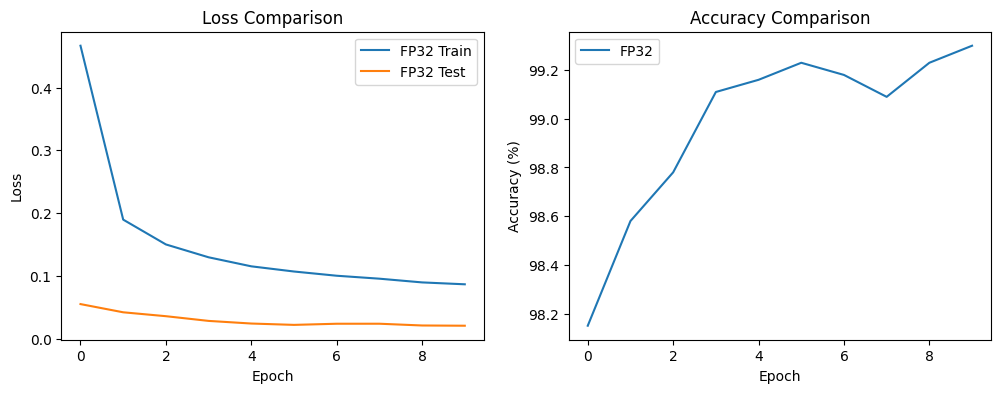


Model Size Comparison:


In [22]:
# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fp32_train_loss, label='FP32 Train')
plt.plot(fp32_test_loss, label='FP32 Test')
#plt.plot(qat_train_loss, label='QAT Train')
#plt.plot(qat_test_loss, label='QAT Test')
plt.title('Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fp32_acc, label='FP32')
#plt.plot(qat_acc, label='QAT')
plt.title('Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# Compare model sizes
torch.save(model_fp32.state_dict(), 'fp32_model.pth')
#torch.save(model_int8.state_dict(), 'int8_model.pth')

print("\nModel Size Comparison:")
#print(f"FP32 Model Size: {os.path.getsize('fp32_model.pth')/1024:.2f} KB")
#print(f"INT8 Model Size: {os.path.getsize('int8_model.pth')/1024:.2f} KB")

# Export to TorchScript
scripted_fp32 = torch.jit.script(model_fp32.to('cpu'))
#scripted_int8 = torch.jit.script(model_int8)
scripted_fp32.save('fp32_model.pt')
#scripted_int8.save('int8_model.pt')

In [ ]:
# Cleanup
try:
    os.remove('fp32_model.pth')
    os.remove('int8_model.pth')
    os.remove('fp32_model.pt')
    os.remove('int8_model.pt')
except:
    pass